In [1]:
%cd /data/codes/prep_gopt/egs/librispeech/s5/

from pandarallel import pandarallel
from asr import Whisper_STT
from glob import glob
import soundfile as sf
import pandas as pd
import librosa
import random
import json
import re
import os

pandarallel.initialize(nb_workers=5, progress_bar=True)

/data/codes/prep_gopt/egs/librispeech/s5
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path = "/data/codes/prep_gopt/egs/librispeech/s5/data/stt/processed/filtered_sents_type_9.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,sent
0,"{""start_time"": 14.415, ""end_time"": 20.945, ""te..."
1,"{""start_time"": 7.08, ""end_time"": 15.23, ""text""..."
2,"{""start_time"": 12.4, ""end_time"": 19.71, ""text""..."
3,"{""start_time"": 28.11, ""end_time"": 29.35, ""text..."
4,"{""start_time"": 6.175, ""end_time"": 11.620000000..."


In [3]:
df.shape

(96840, 1)

In [22]:
in_dir = "/data/audio_data/prep_submission_audio/9"
out_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/wavs"

def extract_audio(sent):
    sent = json.loads(sent)
    in_wav = f'{in_dir}/{sent["id"]}.wav'
    out_wav = f'{out_dir}/{sent["utt_id"]}.wav'
    
    start_indice = int(sent["start_time"] * 16000)
    end_indice = int(sent["end_time"] * 16000)
    
    waveform, sr = librosa.load(in_wav, sr=16000)
    sf.write(out_wav, data=waveform[start_indice:end_indice], samplerate=sr)
    return sent

df.sent.apply(extract_audio)

0        {'start_time': 14.415, 'end_time': 20.945, 'te...
1        {'start_time': 7.08, 'end_time': 15.23, 'text'...
2        {'start_time': 12.4, 'end_time': 19.71, 'text'...
3        {'start_time': 28.11, 'end_time': 29.35, 'text...
4        {'start_time': 6.175, 'end_time': 11.620000000...
                               ...                        
96835    {'start_time': 119.66, 'end_time': 120.49, 'te...
96836    {'start_time': 43.75, 'end_time': 49.57, 'text...
96837    {'start_time': 109.99, 'end_time': 111.31, 'te...
96838    {'start_time': 9.565000000000001, 'end_time': ...
96839    {'start_time': 22.71, 'end_time': 26.9, 'text'...
Name: sent, Length: 96840, dtype: object

154.9592986111111


<Axes: >

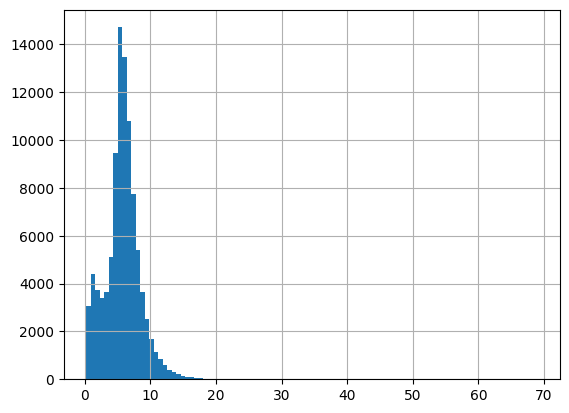

In [24]:
duration = df.sent.apply(lambda x: json.loads(x)["end_time"] - json.loads(x)["start_time"])
print(duration.sum()/3600)
duration.hist(bins=100)

In [25]:
seleted_data = df[(duration > 1) & (duration < 20)].reset_index()
seleted_data["sent"] = seleted_data.sent.apply(lambda x: json.loads(x))

In [16]:
def normalize(text):
    text = re.sub('[\!@#$%^&*\(\)\\\.\'\"\,\?\;\:\+\-\_\/\|~`]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.upper().strip()
    return text

In [28]:
wav_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/wavs"

seleted_data["text"] = seleted_data.sent.parallel_apply(lambda x: normalize(x["text"]))
seleted_data["wav_path"] = seleted_data.sent.parallel_apply(lambda x: os.path.join(wav_dir, f'{x["utt_id"]}.wav'))
seleted_data["utt_id"] = seleted_data.sent.parallel_apply(lambda x: x["utt_id"])
seleted_data["spk_id"] = ['0'*(8-len(str(spk_id))) + f'{spk_id}' for spk_id in range(seleted_data.shape[0])]

seleted_data.sort_values("utt_id", inplace=True)

<Axes: >

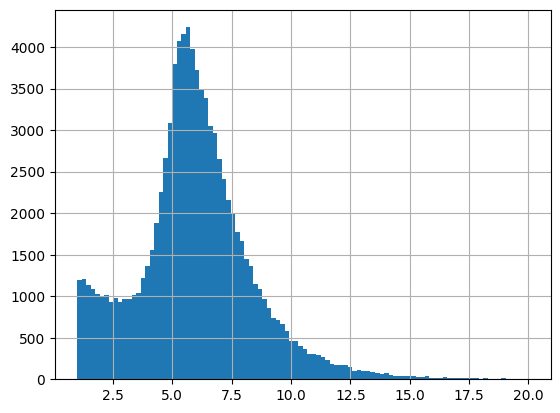

In [32]:
duration[(duration > 1) & (duration < 20)].hist(bins=100)

In [33]:
def check_audio(path):
    wav, sr = librosa.load(path, sr=16000)
    return wav.shape[0]/sr

duration_1 = seleted_data["wav_path"].parallel_apply(lambda x: check_audio(x))
seleted_data = seleted_data[(duration_1>1)]

In [18]:
seleted_data[90000:][["wav_path", "text"]].to_csv("/home/tuyendv/projects/speech_to_text/data/test.csv", index=None, header=None, sep="|")
seleted_data[:90000][["wav_path", "text"]].to_csv("/home/tuyendv/projects/speech_to_text/data/train.csv", index=None, header=None, sep="|")

In [32]:
def create_text_file(f, first_column, second_column):
    line = f'{first_column}\t{second_column}'
    f.write(line + "\n")

data_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/train_processed_type_10"
# os.mkdir(data_dir)
wavscp_path = f'{data_dir}/wav.scp'
text_path = f'{data_dir}/text'
spk2utt_path = f'{data_dir}/spk2utt'
utt2spk_path = f'{data_dir}/utt2spk'

with open(wavscp_path, "w", encoding="utf-8") as f:
    seleted_data[0:90000].apply(lambda x: create_text_file(f, x["utt_id"], x["wav_path"]), axis=1)
    
with open(text_path, "w", encoding="utf-8") as f:
    seleted_data[0:90000].apply(lambda x: create_text_file(f, x["utt_id"], x["text"]), axis=1)
    
with open(spk2utt_path, "w", encoding="utf-8") as f:
    seleted_data[0:90000].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)
    
with open(utt2spk_path, "w", encoding="utf-8") as f:
    seleted_data[0:90000].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)

In [33]:
def create_text_file(f, first_column, second_column):
    line = f'{first_column}\t{second_column}'
    f.write(line + "\n")


data_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/test_processed_type_10"
os.mkdir(data_dir)
wavscp_path = f'{data_dir}/wav.scp'
text_path = f'{data_dir}/text'
spk2utt_path = f'{data_dir}/spk2utt'
utt2spk_path = f'{data_dir}/utt2spk'

with open(wavscp_path, "w", encoding="utf-8") as f:
    seleted_data[90000:].apply(lambda x: create_text_file(f, x["utt_id"], x["wav_path"]), axis=1)
    
with open(text_path, "w", encoding="utf-8") as f:
    seleted_data[90000:].apply(lambda x: create_text_file(f, x["utt_id"], x["text"]), axis=1)
    
with open(spk2utt_path, "w", encoding="utf-8") as f:
    seleted_data[90000:].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)
    
with open(utt2spk_path, "w", encoding="utf-8") as f:
    seleted_data[90000:].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)